In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
import os

In [2]:
data = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd4\set1_013_3_11.pkl')

In [365]:
centers_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd8'
proximity_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs\cd8'

sets = ['set3']
patch_centers = {}
patch_proxi = {}
for s in sets:
    patch_centers[s] = pd.read_csv(os.path.join(centers_dir, s + '_centers.csv'), index_col=0)
    patch_proxi[s] = pd.read_csv(os.path.join(proximity_dir, s + '.csv'), index_col=0)
    patch_proxi[s]['patch_id'] = patch_centers[s]['patch_id'].to_list()
    patch_proxi[s]['cellID'] = patch_centers[s]['cellID'].to_list()

In [85]:
set1_proxi['patch_id'] = set1_centers['patch_id'].to_list()
set1_proxi['cellID'] = set1_centers['cellID'].tolist()

In [78]:
cell_patches = set1_centers[set1_centers['cellID'] == '013_3']

node_importance = np.sum(data['node_mask'], axis=1)
node_importance = node_importance / node_importance.max()
cell_patches['node_importance'] = node_importance
motif_patches = cell_patches[cell_patches['node_importance'] > 0.1]
motif_features = set1_proxi[set1_proxi['patch_id'].isin(motif_patches['patch_id'].tolist())]

patches = motif_patches['patch_id'].to_list()
motif_edges = []
for i in range(data['explained_edges'].shape[1]):
    patch1 = '013_3_' + str(data['explained_edges'][0, i])
    patch2 = '013_3_' + str(data['explained_edges'][1, i])
    if patch1 in motif_patches['patch_id'].tolist() and patch2 in motif_patches['patch_id'].tolist():
        motif_edges.append((patches.index(patch1), patches.index(patch2)))

C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\3364731012.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_patches['node_importance'] = node_importance


In [369]:
patch_explaination_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd8\raw_explanation'
patch_l = os.listdir(patch_explaination_dir)
patch_l.sort()

out_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd8\detected_motifs'

In [371]:
for fn in tqdm(patch_l):
    if not fn.endswith('.pkl'):
        continue
    if fn.split('_')[0] not in sets:
        continue
    data = pd.read_pickle(os.path.join(patch_explaination_dir, fn))

    s = fn.split('_')[0]
    cell = fn.split('_')[1] + '_' + fn.split('_')[2] 
    patch = cell + '_' + fn.split('_')[3]
    patch = patch.split('.')[0]

    centers = patch_centers[s]
    proxi = patch_proxi[s]
    node_importance = np.sum(data['node_mask'], axis=1)
    node_importance = node_importance / node_importance.max()

    cell_patches = centers[centers['cellID'] == cell]
    cell_patches['node_importance'] = node_importance
    motif_patches = cell_patches[cell_patches['node_importance'] > 0.1]
    motif_features = proxi[proxi['patch_id'].isin(motif_patches['patch_id'])]

    patches = motif_patches['patch_id'].to_list()
    motif_edges = []
    for i in range(data['explained_edges'].shape[1]):
        patch1 = cell + '_' + str(data['explained_edges'][0, i])
        patch2 = cell + '_' + str(data['explained_edges'][1, i])
        if patch1 in motif_patches['patch_id'].tolist() and patch2 in motif_patches['patch_id'].tolist():
            motif_edges.append((patches.index(patch1), patches.index(patch2)))
    
    with open(os.path.join(out_dir, fn), 'wb') as f:
        pickle.dump({'motif_patches': motif_patches, 'motif_features': motif_features, 'motif_edges': motif_edges}, f)

  0%|          | 0/3188 [00:00<?, ?it/s]C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\1598768988.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_patches['node_importance'] = node_importance
 53%|█████▎    | 1689/3188 [00:00<00:00, 2755.89it/s]C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\1598768988.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_patches['node_importance'] = node_importance
C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\1598768988.py:19: SettingWithCopyWa

# Motif visalization

In [188]:
import tifffile
from skimage.filters import threshold_otsu

In [184]:
cd4_pos = cd4_pos = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_3d_pos_cd4.csv',index_col=0)
cd8_pos = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_3d_pos_cd8.csv',index_col=0)

In [185]:
scale = 249.6/2304
z_scale = 0.3

In [186]:
def dapi_scatter(dapi_dir, cell, cell_pos):
    dapi = tifffile.imread(dapi_dir)
    cell_center = cell_pos[cell_pos['cellID']==cell].values.flatten()
    cell_center = cell_center[:3].astype('float')

    thre = threshold_otsu(dapi)
    dapi_scatter = np.where(dapi>0)
    dapi_df = pd.DataFrame({'row':list(dapi_scatter[0]), 'col':list(dapi_scatter[1]),'z':[25]*dapi_scatter[0].shape[0]})
    
    d = np.sqrt(np.sum((dapi_df.values - cell_center)**2, axis=1)) * scale
    dapi_df['dist'] = list(d)
    dapi_df = dapi_df[dapi_df['dist'] < 30]
    return dapi_df

In [215]:
dapi_df = dapi_scatter(r'..\..\coculture_diagonal\primed_pbmc\00_masks\all_cells\013_mask.tif', '013_3', cd4_pos)

In [204]:
explanation = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd4\raw_explanation\set1_013_3_11.pkl')
node_importance = np.sum(explanation['node_mask'], axis=1) 
node_importance = node_importance / node_importance.max()
edge_importance = explanation['edge_mask']
edge_importance = edge_importance / edge_importance.max()

edge_index = explanation['explained_edges']

In [205]:
cd4_set1_centers = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd4\set1_centers.csv',index_col=0)

In [206]:
cell_patches = cd4_set1_centers[cd4_set1_centers['cellID'] == '013_3']

In [210]:
cell_patches.reset_index(drop=True, inplace=True)

C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\152525540.py:6: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.pane.fill = False
C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\152525540.py:7: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.pane.fill = False
C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\152525540.py:8: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.fill = False
C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\152525540.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


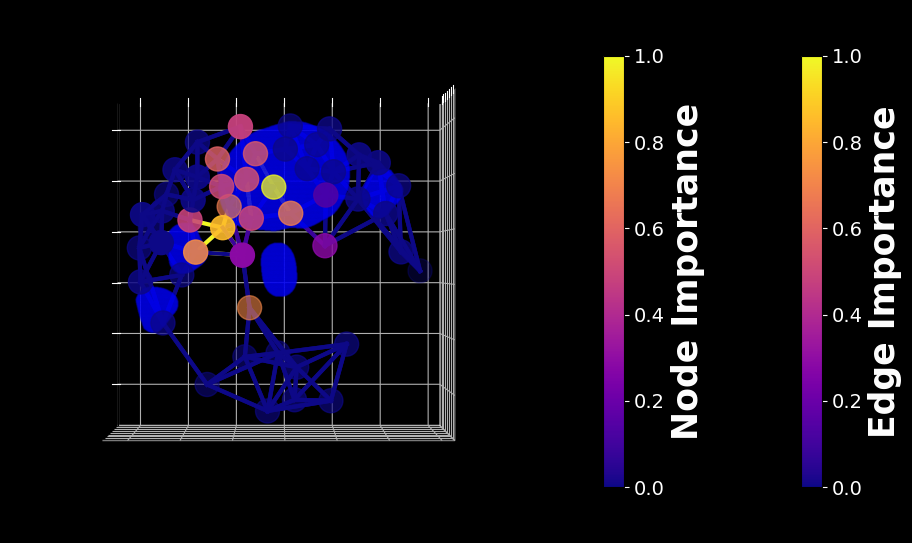

In [217]:
with plt.rc_context({'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'}):
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(projection='3d')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.invert_zaxis()
    

    ax.scatter(dapi_df['row']*scale, dapi_df['col']*scale, dapi_df['z']*z_scale, '.', c='blue', s=0.5, alpha=0.1)

    node_cmap = plt.cm.plasma

    node_c = node_cmap(node_importance)

    ax.scatter(cell_patches['row']*scale, cell_patches['col']*scale, cell_patches['z']*z_scale, '.', c=node_c, s=300)
    

    edge_cmap = plt.cm.plasma
    for i in range(edge_importance.shape[0]):
        edge_c = edge_cmap(edge_importance[i])
        ax.plot([cell_patches.loc[edge_index[0][i]]['row'].astype('float')*scale, cell_patches.loc[edge_index[1][i]]['row'].astype('float')*scale],
                [cell_patches.loc[edge_index[0][i]]['col'].astype('float')*scale, cell_patches.loc[edge_index[1][i]]['col'].astype('float')*scale],
                [cell_patches.loc[edge_index[0][i]]['z'].astype('float')*z_scale, cell_patches.loc[edge_index[1][i]]['z'].astype('float')*z_scale],
                c=edge_c,linewidth=3)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    edge_mappable = plt.cm.ScalarMappable(cmap=edge_cmap)
    edge_cb = plt.colorbar(edge_mappable, ax=ax, label='Edge Importance', pad=0.1, shrink=0.8)
    edge_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    edge_cb.set_label('Edge Importance', color='white', weight='bold', fontsize=25)

    node_mappable = plt.cm.ScalarMappable(cmap=node_cmap)
    node_cb = plt.colorbar(node_mappable, ax=ax, label='Node Importance', pad=0.1, shrink=0.8)
    node_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    node_cb.set_label('Node Importance', color='white', weight='bold', fontsize=25)

    ax.view_init(90, 0)
    plt.tight_layout()
    plt.show()
    # plt.savefig(r'.\figures\cci_motif\bm_001_01_00_graph_importance.png')

In [221]:
feature_importance = np.sum(explanation['node_mask'], axis=0)

In [228]:
important_idx = feature_importance.argsort()
important_idx = important_idx[::-1]
important_idx = important_idx[:10]

In [231]:
gene_pairs = cd4_central_proxi['set1'].columns[:15]

In [239]:
with rc_context({'text.color': 'black', 'axes.labelcolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'font.size':18}):
    ax,fig = plt.subplots(1,1,figsize=(7,5))
    sns.barplot(x=feature_importance[important_idx],y=gene_pairs[important_idx],ax=ax)
    ax.set_xlabel('Feature Importance')
    plt.tight_layout()
    plt.savefig(r'.\figures\cd4_013_03_11_feature_importance.png')

AttributeError: 'Figure' object has no attribute 'barh'

# Motif embedding analysis

In [372]:
import scanpy as sc
from matplotlib import rc_context

In [376]:
cd4_motif_embedding = {}
cd8_motif_embedding = {}
sets = ['set1','set2','set3','set4']
in_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer'

for s in sets:
    cd4_motif_embedding[s] = pd.read_csv(os.path.join(in_dir, 'cd4', 'motif_embedding', s + '_motif_embedding.csv'))
    cd8_motif_embedding[s] = pd.read_csv(os.path.join(in_dir, 'cd8', 'motif_embedding', s + '_motif_embedding.csv'))

In [377]:
pooled_embedding = {'cd4':{}, 'cd8':{}}
for k in cd4_motif_embedding.keys():
    pooled_embedding['cd4'][k] = cd4_motif_embedding[k].groupby('motif_id').mean()
    pooled_embedding['cd8'][k] = cd8_motif_embedding[k].groupby('motif_id').mean()

C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\3430353846.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pooled_embedding['cd4'][k] = cd4_motif_embedding[k].groupby('motif_id').mean()
C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\3430353846.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pooled_embedding['cd8'][k] = cd8_motif_embedding[k].groupby('motif_id').mean()
C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\3430353846.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either spec

In [378]:
cd4_central_proxi = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd4_central_proxi.pkl')
cd8_central_proxi = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd8_central_proxi.pkl')

In [379]:
cd4_central_proxi['set1']

,IL6_IL8,IL6_ACTb,IL6_CD45,IL6_IFNa,IL6_COL1A1,IL8_ACTb,IL8_CD45,IL8_IFNa,IL8_COL1A1,ACTb_CD45,...,CD45_IFNa,CD45_COL1A1,IFNa_COL1A1,patch_id,cellID,row,col,z,KI67,KI67_label
24,0.000000,1.565258,-2.160404,-0.897366,-0.671220,0.000000,0.000000,0.000000,0.000000,-4.279193,...,-0.431094,-0.429522,3.331906,000_1_24,000_1,1260.500000,1614.724138,27.310345,0.006915,KI67-
34,-0.416588,-1.391371,2.393345,-0.764924,-1.330752,-1.418932,-0.754767,1.362711,0.234447,-0.860775,...,-0.777725,-0.370854,-1.295841,000_1_34,000_1,1105.051282,1564.076923,8.692308,0.006915,KI67-
30,0.000000,1.491588,-0.077757,-0.593521,-0.990164,0.000000,0.000000,0.000000,0.000000,-2.631141,...,-0.619745,0.088991,0.740256,000_1_30,000_1,1162.555556,1490.400000,7.000000,0.006915,KI67-
16,-1.005174,-4.321532,3.546264,-0.587912,5.120903,0.252696,-1.967545,-0.514091,-0.690103,-4.713388,...,0.697606,0.280950,-0.380647,000_1_16,000_1,1196.276923,1687.446154,8.861538,0.006915,KI67-
11,0.000000,0.006353,-0.344862,-0.522035,2.002284,0.000000,0.000000,0.000000,0.000000,0.608863,...,0.373671,-1.051093,-0.598155,000_1_11,000_1,1263.971831,1497.971831,33.591549,0.006915,KI67-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12208,0.000000,0.084381,-0.505366,0.000000,0.153397,0.000000,0.000000,0.000000,0.000000,0.072326,...,0.000000,-0.452369,0.000000,029_6_37,029_6,1428.829268,1833.365854,23.780488,0.011289,KI67-
12176,4.374105,-3.387844,1.122928,-0.721548,-0.488155,-4.962098,-1.014155,5.183842,-0.612930,-0.428273,...,-2.243951,0.911416,-0.689537,029_6_5,029_6,1591.527778,1887.875000,12.041667,0.011289,KI67-
12188,1.351733,-1.457463,1.157380,1.673853,-3.286476,0.003650,1.171526,4.624018,-2.247523,-0.393083,...,2.955300,-1.521993,-2.227632,029_6_17,029_6,1411.508197,1881.524590,15.393443,0.011289,KI67-
12204,0.000000,0.000000,0.000000,0.000000,0.000000,-0.964163,-0.458697,1.165673,0.651154,0.155877,...,-0.468130,1.235771,-0.354361,029_6_33,029_6,1430.422222,1922.177778,8.933333,0.011289,KI67-


In [380]:
cd4_labels = {'set1':[], 'set2':[], 'set3':[], 'set4':[]}
cd8_labels = {'set1':[], 'set2':[], 'set3':[], 'set4':[]}
for k in pooled_embedding['cd4'].keys():
    for item in pooled_embedding['cd4'][k].index:
        patch = item[5:]
        if patch in cd4_central_proxi[k]['patch_id'].tolist():
            idx = cd4_central_proxi[k]['patch_id'].tolist().index(patch)
            cd4_labels[k].append('CD4_' + cd4_central_proxi[k]['KI67_label'].tolist()[idx])
        else:
            cd4_labels[k].append('unknown')
for k in pooled_embedding['cd8'].keys():
    for item in pooled_embedding['cd8'][k].index:
        patch = item[5:]
        if patch in cd8_central_proxi[k]['patch_id'].tolist():
            idx = cd8_central_proxi[k]['patch_id'].tolist().index(patch)
            cd8_labels[k].append('CD8_' + cd8_central_proxi[k]['KI67_label'].tolist()[idx])
        else:
            cd8_labels[k].append('unknown')

In [381]:
set1_data = pooled_embedding['cd4']['set1'].append(pooled_embedding['cd8']['set1'])
set1_data['label'] = cd4_labels['set1'] + cd8_labels['set1']
set1_data = set1_data[set1_data['label'] != 'unknown']

set2_data = pooled_embedding['cd4']['set2'].append(pooled_embedding['cd8']['set2'])
set2_data['label'] = cd4_labels['set2'] + cd8_labels['set2']
set2_data = set2_data[set2_data['label'] != 'unknown']

set3_data = pooled_embedding['cd4']['set3'].append(pooled_embedding['cd8']['set3'])
set3_data['label'] = cd4_labels['set3'] + cd8_labels['set3']
set3_data = set3_data[set3_data['label'] != 'unknown']

set4_data = pooled_embedding['cd4']['set4'].append(pooled_embedding['cd8']['set4'])
set4_data['label'] = cd4_labels['set4'] + cd8_labels['set4']
set4_data = set4_data[set4_data['label'] != 'unknown']

C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\759445342.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  set1_data = pooled_embedding['cd4']['set1'].append(pooled_embedding['cd8']['set1'])
C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\759445342.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  set2_data = pooled_embedding['cd4']['set2'].append(pooled_embedding['cd8']['set2'])
C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\759445342.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  set3_data = pooled_embedding['cd4']['set3'].append(pooled_embedding['cd8']['set3'])
C:\Users\zfang38\AppData\Local\Temp\ipykernel_24808\759445342.py:13: FutureWarning: The frame.append method is deprecated and will be remov

In [382]:
set1_embedding_adata = sc.AnnData(X=set1_data.drop(columns=['label']).values.astype('float'))
set1_embedding_adata.obs['label'] = pd.Categorical(set1_data['label'], categories=['CD4_KI67+', 'CD4_KI67-', 'CD8_KI67+', 'CD8_KI67-'])
set1_embedding_adata.obs['motif_id'] = set1_data.index

In [383]:
sc.pp.neighbors(set1_embedding_adata, use_rep='X', n_neighbors=15)

In [384]:
sc.tl.umap(set1_embedding_adata)
sc.tl.tsne(set1_embedding_adata)

c:\Users\zfang38\AppData\Local\anaconda3\envs\skim\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


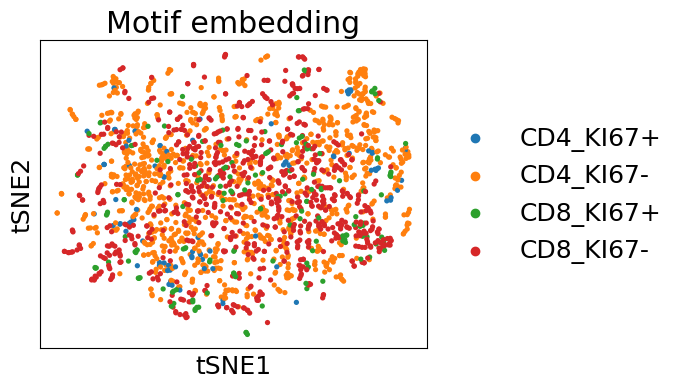

In [385]:
with rc_context({'figure.figsize': (5, 4), 'font.size': 18}):
    sc.pl.tsne(set1_embedding_adata, color='label', title='Motif embedding', save='_set1_motif_embedding.png')

In [386]:
set2_embedding_adata = sc.AnnData(X=set2_data.drop(columns=['label']).values.astype('float'))
set2_embedding_adata.obs['label'] = pd.Categorical(set2_data['label'], categories=['CD4_KI67+', 'CD4_KI67-', 'CD8_KI67+', 'CD8_KI67-'])
set2_embedding_adata.obs['motif_id'] = set2_data.index

sc.pp.neighbors(set2_embedding_adata, use_rep='X', n_neighbors=15)

sc.tl.umap(set2_embedding_adata)
sc.tl.tsne(set2_embedding_adata)

c:\Users\zfang38\AppData\Local\anaconda3\envs\skim\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


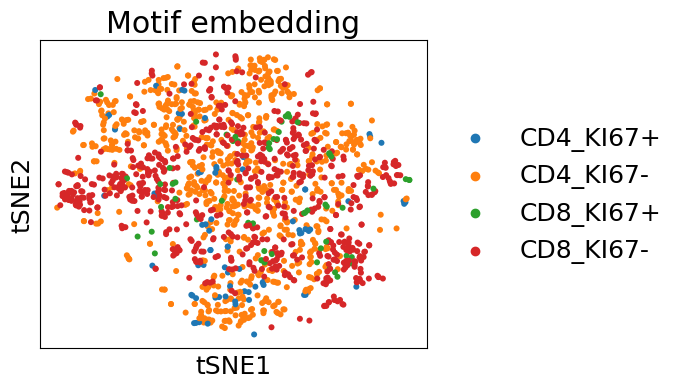

In [388]:
with rc_context({'figure.figsize': (5, 4), 'font.size': 18}):
    sc.pl.tsne(set2_embedding_adata, color='label', title='Motif embedding', save='_set2_motif_embedding.png')

In [389]:
set3_embedding_adata = sc.AnnData(X=set3_data.drop(columns=['label']).values.astype('float'))
set3_embedding_adata.obs['label'] = pd.Categorical(set3_data['label'], categories=['CD4_KI67+', 'CD4_KI67-', 'CD8_KI67+', 'CD8_KI67-'])
set3_embedding_adata.obs['motif_id'] = set3_data.index

sc.pp.neighbors(set3_embedding_adata, use_rep='X', n_neighbors=15)

sc.tl.umap(set3_embedding_adata)
sc.tl.tsne(set3_embedding_adata)

c:\Users\zfang38\AppData\Local\anaconda3\envs\skim\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


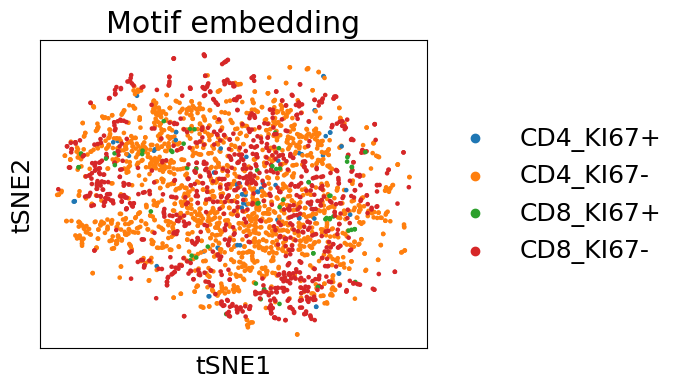

In [390]:
with rc_context({'figure.figsize': (5, 4), 'font.size': 18}):
    sc.pl.tsne(set3_embedding_adata, color='label', title='Motif embedding', save='_set3_motif_embedding.png')

In [391]:
set4_embedding_adata = sc.AnnData(X=set4_data.drop(columns=['label']).values.astype('float'))
set4_embedding_adata.obs['label'] = pd.Categorical(set4_data['label'], categories=['CD4_KI67+', 'CD4_KI67-', 'CD8_KI67+', 'CD8_KI67-'])
set4_embedding_adata.obs['motif_id'] = set4_data.index

sc.pp.neighbors(set4_embedding_adata, use_rep='X', n_neighbors=15)

sc.tl.umap(set4_embedding_adata)
sc.tl.tsne(set4_embedding_adata)

c:\Users\zfang38\AppData\Local\anaconda3\envs\skim\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


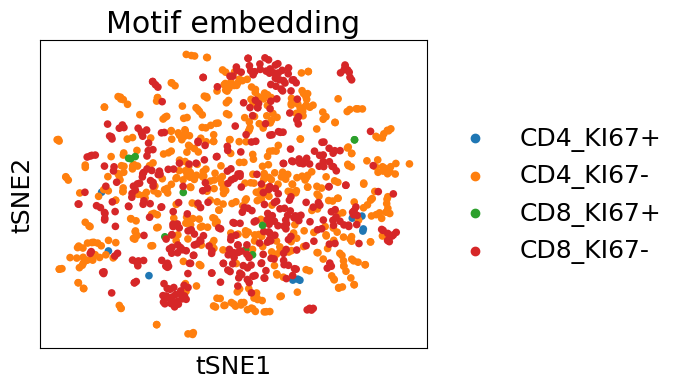

In [433]:
with rc_context({'figure.figsize': (5, 4), 'font.size': 18}):
    sc.pl.tsne(set4_embedding_adata, color='label', title='Motif embedding', save='_set4_motif_embedding.png')

In [393]:
sc.write(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd4\set1_motif_embedding.h5ad', set1_embedding_adata)
sc.write(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd4\set2_motif_embedding.h5ad', set2_embedding_adata)
sc.write(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd4\set3_motif_embedding.h5ad', set3_embedding_adata)
sc.write(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd4\set4_motif_embedding.h5ad', set4_embedding_adata)

# using mean proximity of each motif

In [394]:
cd4_proxi = {}
cd8_proxi = {}
sets = ['set1', 'set2', 'set3', 'set4']
in_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs'
for s in sets:
    cd4_proxi[s] = pd.read_csv(os.path.join(in_dir, 'cd4', s + '.csv'), index_col=0)
    cd8_proxi[s] = pd.read_csv(os.path.join(in_dir, 'cd8', s + '.csv'), index_col=0)

cd4_centers = {}
cd8_centers = {}
sets = ['set1', 'set2', 'set3', 'set4']
in_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers'
for s in sets:
    cd4_centers[s] = pd.read_csv(os.path.join(in_dir, 'cd4', s + '_centers.csv'), index_col=0)
    cd8_centers[s] = pd.read_csv(os.path.join(in_dir, 'cd8', s + '_centers.csv'), index_col=0)

for s in sets:
    cd4_proxi[s]['patch_id'] = cd4_centers[s]['patch_id'].to_list()
    cd4_proxi[s]['cellID'] = cd4_centers[s]['cellID'].to_list()
    cd8_proxi[s]['patch_id'] = cd8_centers[s]['patch_id'].to_list()
    cd8_proxi[s]['cellID'] = cd8_centers[s]['cellID'].to_list()

In [395]:
set1_motifs = set1_embedding_adata.obs['motif_id'].tolist()
set1_pooled_proxi = []
for i,item in enumerate(set1_motifs):
    cell_type = set1_data['label'].tolist()[i].split('_')[0]
    if cell_type == 'CD4':
        motif_embedding = cd4_motif_embedding['set1'][cd4_motif_embedding['set1']['motif_id'] == item]
        motif_proxi = cd4_proxi['set1'][cd4_proxi['set1']['patch_id'].isin(motif_embedding['patch_id'])]
        pooled_proxi = motif_proxi.mean()
        set1_pooled_proxi.append(pooled_proxi)
    else:
        motif_embedding = cd8_motif_embedding['set1'][cd8_motif_embedding['set1']['motif_id'] == item]
        motif_proxi = cd8_proxi['set1'][cd8_proxi['set1']['patch_id'].isin(motif_embedding['patch_id'])]
        pooled_proxi = motif_proxi.mean()
        set1_pooled_proxi.append(pooled_proxi)

In [396]:
set1_pooled_proxi = pd.concat(set1_pooled_proxi, axis=1).T
set1_pooled_proxi.drop(columns=['patch_id', 'cellID'], inplace=True)
set1_pooled_proxi.fillna(0, inplace=True)

In [397]:
set1_proxi_adata = sc.AnnData(X=set1_pooled_proxi.values.astype('float'))
set1_proxi_adata.obs['label'] = set1_adata.obs['label']
set1_proxi_adata.obs['motif_id'] = set1_adata.obs['motif_id']

sc.pp.neighbors(set1_proxi_adata, use_rep='X', n_neighbors=15)

sc.tl.umap(set1_proxi_adata)
sc.tl.tsne(set1_proxi_adata)

c:\Users\zfang38\AppData\Local\anaconda3\envs\skim\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


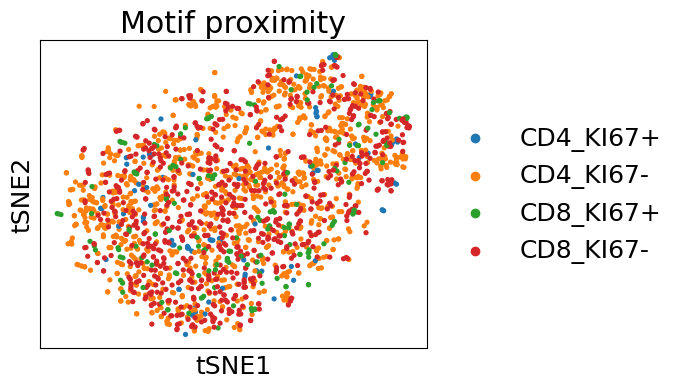

In [398]:
with rc_context({'figure.figsize': (5, 4), 'font.size': 18}):
    sc.pl.tsne(set1_proxi_adata, color='label', title='Motif proximity', save='_set1_motif_proximity.png')

In [399]:
set2_motifs = set2_embedding_adata.obs['motif_id'].tolist()
set2_pooled_proxi = []
for i,item in enumerate(set2_motifs):
    cell_type = set2_data['label'].tolist()[i].split('_')[0]
    if cell_type == 'CD4':
        motif_embedding = cd4_motif_embedding['set2'][cd4_motif_embedding['set2']['motif_id'] == item]
        motif_proxi = cd4_proxi['set2'][cd4_proxi['set2']['patch_id'].isin(motif_embedding['patch_id'])]
        pooled_proxi = motif_proxi.mean()
        set2_pooled_proxi.append(pooled_proxi)
    else:
        motif_embedding = cd8_motif_embedding['set2'][cd8_motif_embedding['set2']['motif_id'] == item]
        motif_proxi = cd8_proxi['set2'][cd8_proxi['set2']['patch_id'].isin(motif_embedding['patch_id'])]
        pooled_proxi = motif_proxi.mean()
        set2_pooled_proxi.append(pooled_proxi)

In [400]:
set2_pooled_proxi = pd.concat(set2_pooled_proxi, axis=1).T
set2_pooled_proxi.drop(columns=['patch_id', 'cellID'], inplace=True)
set2_pooled_proxi.fillna(0, inplace=True)

In [401]:
set2_proxi_adata = sc.AnnData(X=set2_pooled_proxi.values.astype('float'))
set2_proxi_adata.obs['label'] = set2_embedding_adata.obs['label']
set2_proxi_adata.obs['motif_id'] = set2_embedding_adata.obs['motif_id']

sc.pp.neighbors(set2_proxi_adata, use_rep='X', n_neighbors=15)

sc.tl.umap(set2_proxi_adata)
sc.tl.tsne(set2_proxi_adata)

c:\Users\zfang38\AppData\Local\anaconda3\envs\skim\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


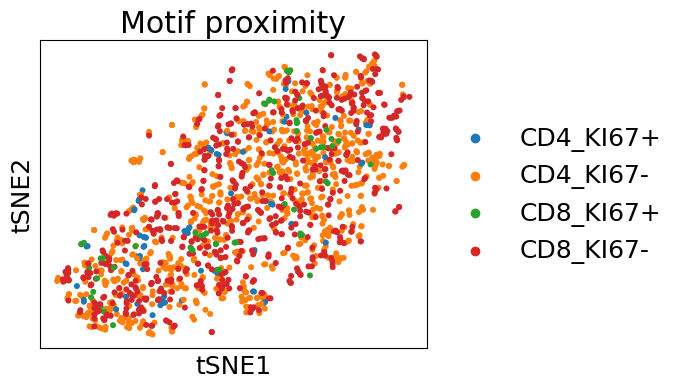

In [402]:
with rc_context({'figure.figsize': (5, 4), 'font.size': 18}):
    sc.pl.tsne(set2_proxi_adata, color='label', title='Motif proximity', save='_set2_motif_proximity.png')

In [403]:
set3_motifs = set3_embedding_adata.obs['motif_id'].tolist()
set3_pooled_proxi = []
for i,item in enumerate(set3_motifs):
    cell_type = set3_data['label'].tolist()[i].split('_')[0]
    if cell_type == 'CD4':
        motif_embedding = cd4_motif_embedding['set3'][cd4_motif_embedding['set3']['motif_id'] == item]
        motif_proxi = cd4_proxi['set3'][cd4_proxi['set3']['patch_id'].isin(motif_embedding['patch_id'])]
        pooled_proxi = motif_proxi.mean()
        set3_pooled_proxi.append(pooled_proxi)
    else:
        motif_embedding = cd8_motif_embedding['set3'][cd8_motif_embedding['set3']['motif_id'] == item]
        motif_proxi = cd8_proxi['set3'][cd8_proxi['set3']['patch_id'].isin(motif_embedding['patch_id'])]
        pooled_proxi = motif_proxi.mean()
        set3_pooled_proxi.append(pooled_proxi)

In [404]:
set3_pooled_proxi = pd.concat(set3_pooled_proxi, axis=1).T
set3_pooled_proxi.drop(columns=['patch_id', 'cellID'], inplace=True)
set3_pooled_proxi.fillna(0, inplace=True)

In [405]:
set3_proxi_adata = sc.AnnData(X=set3_pooled_proxi.values.astype('float'))
set3_proxi_adata.obs['label'] = set3_embedding_adata.obs['label']
set3_proxi_adata.obs['motif_id'] = set3_embedding_adata.obs['motif_id']

sc.pp.neighbors(set3_proxi_adata, use_rep='X', n_neighbors=15)

sc.tl.umap(set3_proxi_adata)
sc.tl.tsne(set3_proxi_adata)

c:\Users\zfang38\AppData\Local\anaconda3\envs\skim\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


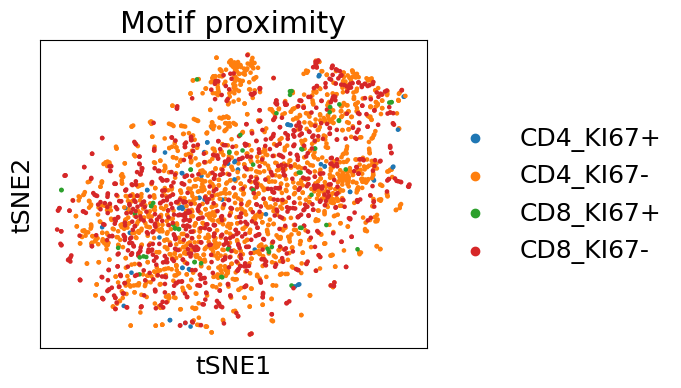

In [406]:
with rc_context({'figure.figsize': (5, 4), 'font.size': 18}):
    sc.pl.tsne(set3_proxi_adata, color='label', title='Motif proximity', save='_set3_motif_proximity.png')

In [407]:
set4_motifs = set4_embedding_adata.obs['motif_id'].tolist()
set4_pooled_proxi = []
for i,item in enumerate(set4_motifs):
    cell_type = set4_data['label'].tolist()[i].split('_')[0]
    if cell_type == 'CD4':
        motif_embedding = cd4_motif_embedding['set4'][cd4_motif_embedding['set4']['motif_id'] == item]
        motif_proxi = cd4_proxi['set4'][cd4_proxi['set4']['patch_id'].isin(motif_embedding['patch_id'])]
        pooled_proxi = motif_proxi.mean()
        set4_pooled_proxi.append(pooled_proxi)
    else:
        motif_embedding = cd8_motif_embedding['set4'][cd8_motif_embedding['set4']['motif_id'] == item]
        motif_proxi = cd8_proxi['set4'][cd8_proxi['set4']['patch_id'].isin(motif_embedding['patch_id'])]
        pooled_proxi = motif_proxi.mean()
        set4_pooled_proxi.append(pooled_proxi)

In [408]:
set4_pooled_proxi = pd.concat(set4_pooled_proxi, axis=1).T
set4_pooled_proxi.drop(columns=['patch_id', 'cellID'], inplace=True)
set4_pooled_proxi.fillna(0, inplace=True)

In [409]:
set4_proxi_adata = sc.AnnData(X=set4_pooled_proxi.values.astype('float'))
set4_proxi_adata.obs['label'] = set4_embedding_adata.obs['label']
set4_proxi_adata.obs['motif_id'] = set4_embedding_adata.obs['motif_id']

sc.pp.neighbors(set4_proxi_adata, use_rep='X', n_neighbors=15)

sc.tl.umap(set4_proxi_adata)
sc.tl.tsne(set4_proxi_adata)

c:\Users\zfang38\AppData\Local\anaconda3\envs\skim\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


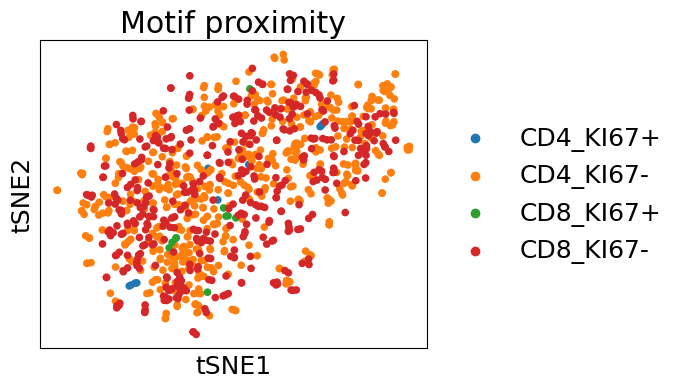

In [410]:
with rc_context({'figure.figsize': (5, 4), 'font.size': 18}):
    sc.pl.tsne(set4_proxi_adata, color='label', title='Motif proximity', save='_set4_motif_proximity.png')

In [411]:
sc.write(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd4\set1_motif_proximity.h5ad', set1_proxi_adata)
sc.write(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd4\set2_motif_proximity.h5ad', set2_proxi_adata)
sc.write(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd4\set3_motif_proximity.h5ad', set3_proxi_adata)
sc.write(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gae_encoder_explainer\cd4\set4_motif_proximity.h5ad', set4_proxi_adata)

# Classification

In [412]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [413]:
motif_train_x_set1,motif_test_x_set1,motif_train_y_set1,motif_test_y_set1 = train_test_split(set1_embedding_adata.X,set1_embedding_adata.obs['label'].tolist(),test_size=0.2,random_state=42)
proxi_train_x_set1,proxi_test_x_set1,proxi_train_y_set1,proxi_test_y_set1 = train_test_split(set1_proxi_adata.X,set1_proxi_adata.obs['label'].tolist(),test_size=0.2,random_state=42)

In [414]:
clf = SVC(kernel='sigmoid',C=1)
clf.fit(motif_train_x_set1,motif_train_y_set1)
prediction = clf.predict(motif_test_x_set1)

l = np.unique(set1_embedding_adata.obs['label'].tolist())
con = confusion_matrix(motif_test_y_set1,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

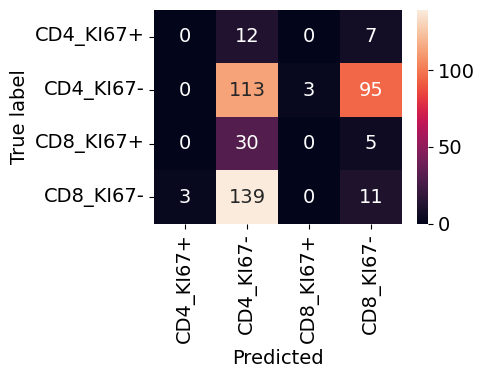

In [415]:
with rc_context({'font.size':14}):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    sns.heatmap(con,annot=True,fmt='d',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(r'.\figures\motif_classification_set1.png',dpi=300)
    plt.show()

In [416]:
clf.fit(proxi_train_x_set1,proxi_train_y_set1)
prediction = clf.predict(proxi_test_x_set1)

l = np.unique(set1_proxi_adata.obs['label'].tolist())
con = confusion_matrix(proxi_test_y_set1,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

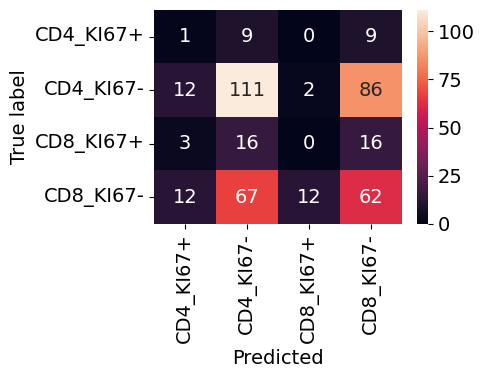

In [417]:
with rc_context({'font.size':14}):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    sns.heatmap(con,annot=True,fmt='d',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(r'.\figures\proxi_classification_set1.png',dpi=300)
    plt.show()

## set 2

In [418]:
motif_train_x_set2,motif_test_x_set2,motif_train_y_set2,motif_test_y_set2 = train_test_split(set2_embedding_adata.X,set2_embedding_adata.obs['label'].tolist(),test_size=0.2,random_state=42)
proxi_train_x_set2,proxi_test_x_set2,proxi_train_y_set2,proxi_test_y_set2 = train_test_split(set2_proxi_adata.X,set2_proxi_adata.obs['label'].tolist(),test_size=0.2,random_state=42)

In [419]:
clf = SVC(kernel='sigmoid',C=1)
clf.fit(motif_train_x_set2,motif_train_y_set2)
prediction = clf.predict(motif_test_x_set2)

l = np.unique(set2_embedding_adata.obs['label'].tolist())
con = confusion_matrix(motif_test_y_set2,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

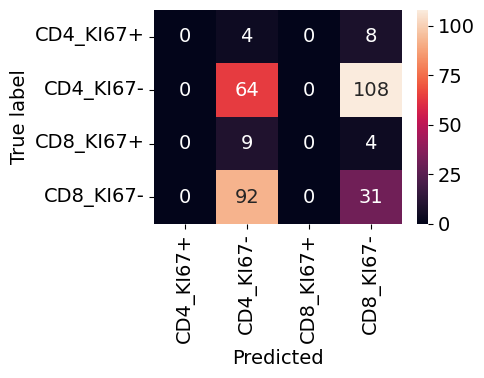

In [420]:
with rc_context({'font.size':14}):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    sns.heatmap(con,annot=True,fmt='d',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(r'.\figures\motif_classification_set2.png',dpi=300)
    plt.show()

In [421]:
clf.fit(proxi_train_x_set2,proxi_train_y_set2)
prediction = clf.predict(proxi_test_x_set2)

l = np.unique(set2_proxi_adata.obs['label'].tolist())
con = confusion_matrix(proxi_test_y_set2,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

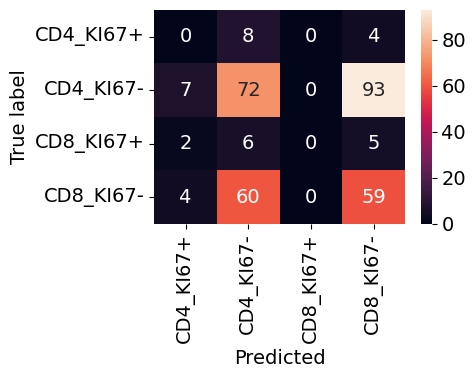

In [422]:
with rc_context({'font.size':14}):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    sns.heatmap(con,annot=True,fmt='d',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(r'.\figures\proxi_classification_set2.png',dpi=300)
    plt.show()

## set 3

In [423]:
motif_train_x_set3,motif_test_x_set3,motif_train_y_set3,motif_test_y_set3 = train_test_split(set3_embedding_adata.X,set3_embedding_adata.obs['label'].tolist(),test_size=0.2,random_state=42)
proxi_train_x_set3,proxi_test_x_set3,proxi_train_y_set3,proxi_test_y_set3 = train_test_split(set3_proxi_adata.X,set3_proxi_adata.obs['label'].tolist(),test_size=0.2,random_state=42)

In [424]:
clf = SVC(kernel='sigmoid',C=1)
clf.fit(motif_train_x_set3,motif_train_y_set3)
prediction = clf.predict(motif_test_x_set3)

l = np.unique(set3_embedding_adata.obs['label'].tolist())
con = confusion_matrix(motif_test_y_set3,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

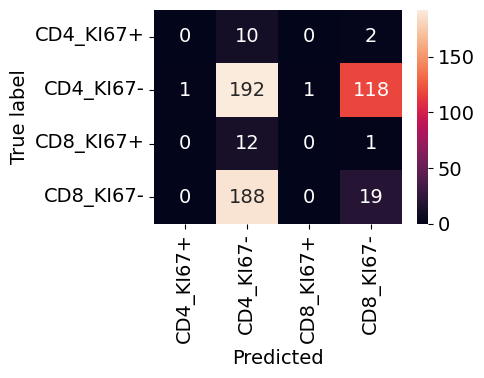

In [425]:
with rc_context({'font.size':14}):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    sns.heatmap(con,annot=True,fmt='d',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(r'.\figures\motif_classification_set3.png',dpi=300)
    plt.show()

In [426]:
clf.fit(proxi_train_x_set3,proxi_train_y_set3)
prediction = clf.predict(proxi_test_x_set3)

l = np.unique(set3_proxi_adata.obs['label'].tolist())
con = confusion_matrix(proxi_test_y_set3,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

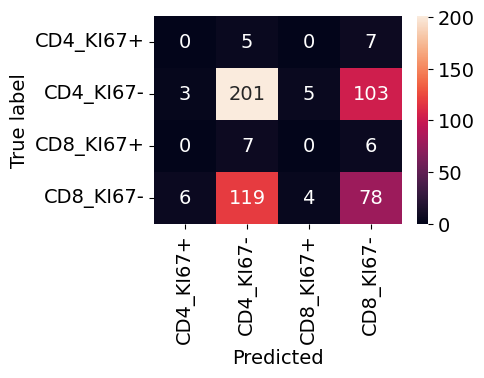

In [427]:
with rc_context({'font.size':14}):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    sns.heatmap(con,annot=True,fmt='d',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(r'.\figures\proxi_classification_set3.png',dpi=300)
    plt.show()

## set 4

In [428]:
motif_train_x_set4,motif_test_x_set4,motif_train_y_set4,motif_test_y_set4 = train_test_split(set4_embedding_adata.X,set4_embedding_adata.obs['label'].tolist(),test_size=0.2,random_state=42)
proxi_train_x_set4,proxi_test_x_set4,proxi_train_y_set4,proxi_test_y_set4 = train_test_split(set4_proxi_adata.X,set4_proxi_adata.obs['label'].tolist(),test_size=0.2,random_state=42)

In [429]:
clf = SVC(kernel='sigmoid',C=1)
clf.fit(motif_train_x_set4,motif_train_y_set4)
prediction = clf.predict(motif_test_x_set4)

l = np.unique(set4_embedding_adata.obs['label'].tolist())
con = confusion_matrix(motif_test_y_set4,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

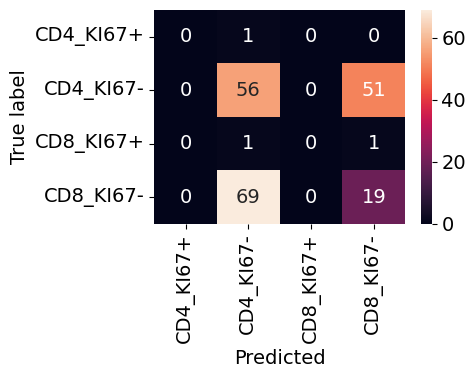

In [430]:
with rc_context({'font.size':14}):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    sns.heatmap(con,annot=True,fmt='d',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(r'.\figures\motif_classification_set4.png',dpi=300)
    plt.show()

In [431]:
clf.fit(proxi_train_x_set4,proxi_train_y_set4)
prediction = clf.predict(proxi_test_x_set4)

l = np.unique(set4_proxi_adata.obs['label'].tolist())
con = confusion_matrix(proxi_test_y_set4,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

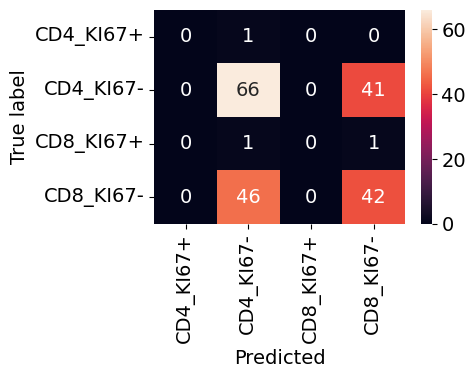

In [432]:
with rc_context({'font.size':14}):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    sns.heatmap(con,annot=True,fmt='d',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(r'.\figures\proxi_classification_set4.png',dpi=300)
    plt.show()